## 프로젝트

## 목차
1. 데이터 준비하기
2. 데이터 시각화
3. CNN 모델링
4. 데이터 imbalance 처리
5. 모델 훈련
6. 결과 확인과 시각화
7. 다양한 훈련 및 훈련 결과 확인

## 루브릭 평가 기준

|평가문항|상세기준|
|:----|:----|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|

### 라이브러리

In [28]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

## 데이터 준비하기

In [49]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel/aiffel_project/exploration_9')
TRAIN_PATH = ROOT_PATH + '/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/data/val/*/*'
TEST_PATH = ROOT_PATH + '/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel/aiffel_project/exploration_9


In [50]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [51]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [52]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/aiffel_project/exploration_9/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/aiffel_project/exploration_9/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [53]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [54]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [55]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [56]:
def get_label(file_path): # 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA" # 폐렴이면 양성(True), 노말이면 음성(False)

In [57]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [58]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [59]:
# train_ds.take(1)은 하나의 데이터만 가져온다는 의미
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [40]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [110]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 데이터 시각화

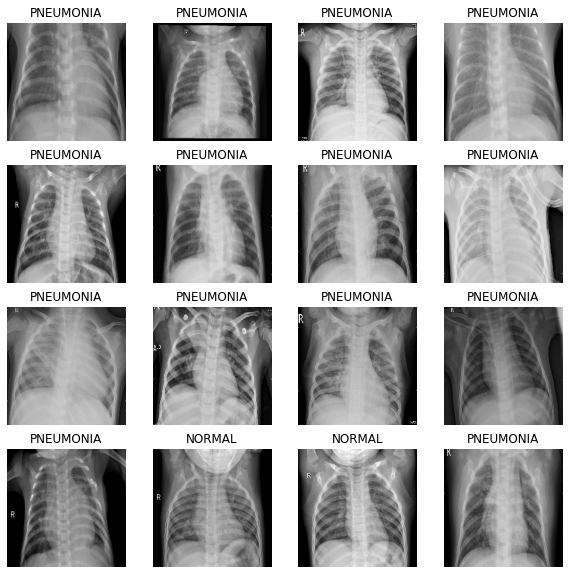

In [49]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## CNN  모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [17]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 데이터 imbalance 처리

In [111]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 모델 훈련

### 데이터 imbalance 처리후

In [35]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [36]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 64s 190ms/step - loss: 0.4178 - accuracy: 0.8022 - precision: 0.9509 - recall: 0.7740 - val_loss: 0.7339 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 190ms/step - loss: 0.2327 - accuracy: 0.9085 - precision: 0.9726 - recall: 0.9024 - val_loss: 1.0303 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 190ms/step - loss: 0.2008 - accuracy: 0.9236 - precision: 0.9777 - recall: 0.9182 - val_loss: 0.2580 - val_accuracy: 0.8779 - val_precision: 0.8576 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 51s 195ms/step - loss: 0.1830 - accuracy: 0.9291 - precision: 0.9772 - recall: 0.9262 - val_loss: 0.0891 - val_accuracy: 0.9683 - val_precision: 0.9621 - val_recall: 0.9961
Epoch 5/25
261/261 [==============================] - 52s 199ms/step - loss: 0.1803 - accura

## 결과 확인과 시각화

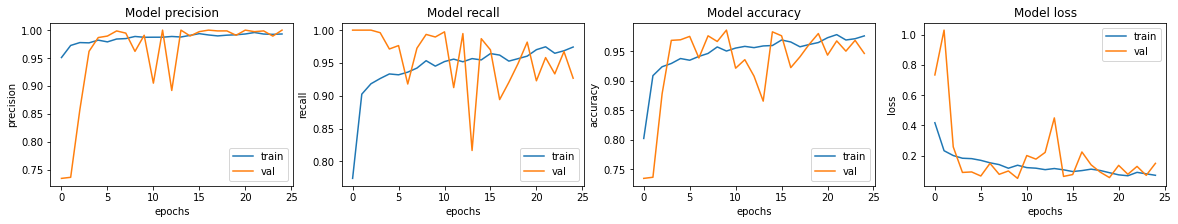

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [38]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.6576 - accuracy: 0.8622 - precision: 0.8378 - recall: 0.9667
Loss: 0.6576338410377502,
Accuracy: 0.8621794581413269,
Precision: 0.8377777934074402,
Recall: 0.9666666388511658


### 데이터 imbalance 생략

In [18]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

Epoch 1/25
261/261 [==============================] - 65s 199ms/step - loss: 0.4039 - accuracy: 0.8254 - precision: 0.9227 - recall: 0.8351 - val_loss: 0.7440 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 51s 197ms/step - loss: 0.2258 - accuracy: 0.9219 - precision: 0.9496 - recall: 0.9453 - val_loss: 1.2633 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 51s 197ms/step - loss: 0.1739 - accuracy: 0.9353 - precision: 0.9563 - recall: 0.9569 - val_loss: 0.1716 - val_accuracy: 0.9231 - val_precision: 0.9082 - val_recall: 0.9961
Epoch 4/25
261/261 [==============================] - 52s 200ms/step - loss: 0.1718 - accuracy: 0.9401 - precision: 0.9583 - recall: 0.9614 - val_loss: 1.3775 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 52s 199ms/step - loss: 0.1465 - accura

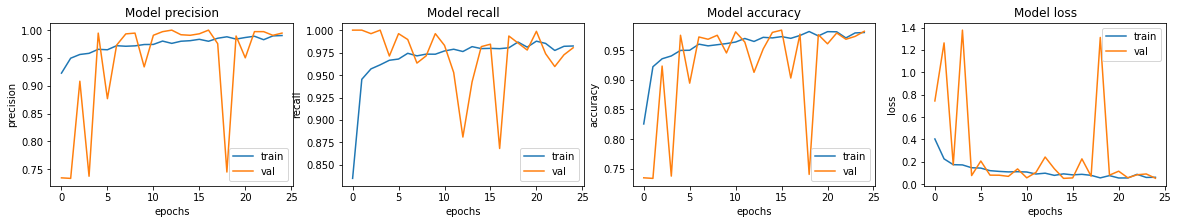

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 113ms/step - loss: 1.3459 - accuracy: 0.7548 - precision: 0.7223 - recall: 0.9872
Loss: 1.3458670377731323,
Accuracy: 0.754807710647583,
Precision: 0.7223264575004578,
Recall: 0.9871794581413269


### 여러가지 테스트

In [41]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [42]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(256, 0.5),
        dense_block(128, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [122]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [123]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 60s 193ms/step - loss: 0.6944 - accuracy: 0.5357 - precision: 0.7384 - recall: 0.5828 - val_loss: 0.6900 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 193ms/step - loss: 0.6936 - accuracy: 0.5402 - precision: 0.7478 - recall: 0.5764 - val_loss: 0.7093 - val_accuracy: 0.2654 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
261/261 [==============================] - 51s 195ms/step - loss: 0.6944 - accuracy: 0.4253 - precision: 0.7291 - recall: 0.3621 - val_loss: 0.7143 - val_accuracy: 0.2635 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


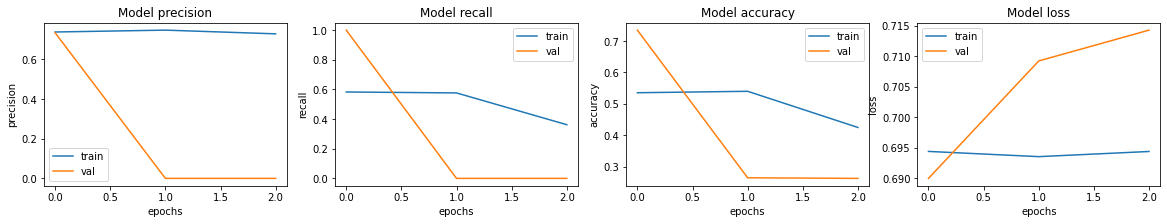

In [124]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [125]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 114ms/step - loss: 0.6915 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6914881467819214,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


In [60]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

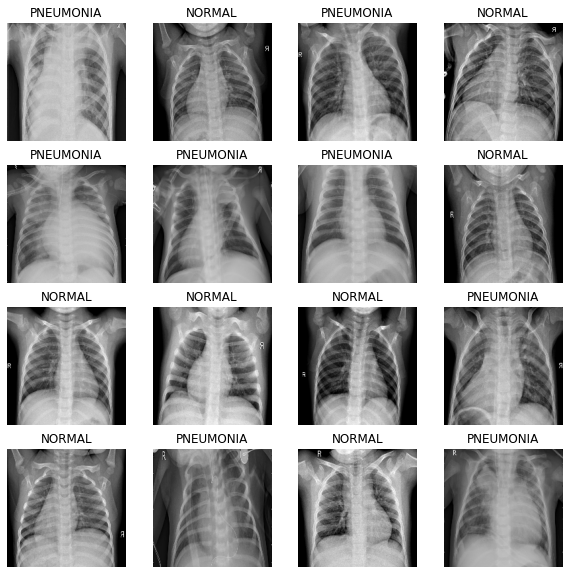

In [61]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [44]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [62]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [63]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        callback[es]
    )

Epoch 1/25
261/261 [==============================] - 59s 190ms/step - loss: 0.4654 - accuracy: 0.7866 - precision: 0.8904 - recall: 0.8133 - val_loss: 0.7975 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 185ms/step - loss: 0.2534 - accuracy: 0.9057 - precision: 0.9366 - recall: 0.9366 - val_loss: 1.4114 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2106 - accuracy: 0.9188 - precision: 0.9458 - recall: 0.9449 - val_loss: 0.5458 - val_accuracy: 0.7394 - val_precision: 0.7379 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1865 - accuracy: 0.9301 - precision: 0.9522 - recall: 0.9540 - val_loss: 0.1087 - val_accuracy: 0.9538 - val_precision: 0.9497 - val_recall: 0.9895
Epoch 5/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1912 - accura

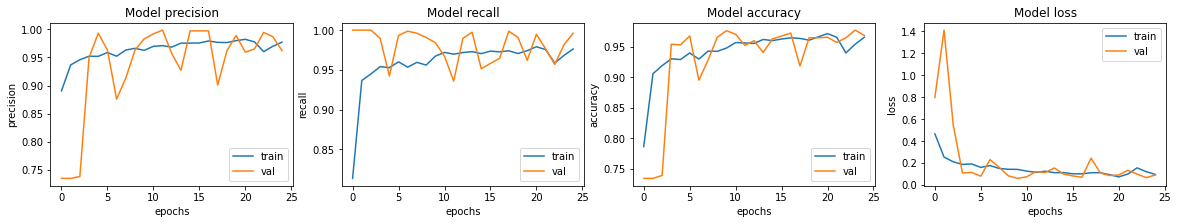

In [64]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [65]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 1.2774 - accuracy: 0.7099 - precision: 0.6830 - recall: 1.0000
Loss: 1.27735435962677,
Accuracy: 0.7099359035491943,
Precision: 0.6830122470855713,
Recall: 1.0


### 다양한 테스트
- filters 값 변경 [64, 128, 256, 512]
<p>39/39 [==============================] - 5s 115ms/step - loss: 0.7076 - accuracy: 0.8141 - precision: 0.7751 - recall: 0.9897
Loss: 0.7075697183609009,
Accuracy: 0.8141025900840759,
Precision: 0.7751004099845886,
Recall: 0.9897435903549194</p>

- units 값 변경 [1024, 512, 256]  
39/39 [==============================] - 5s 113ms/step - loss: 0.7043 - accuracy: <p>0.7917 - precision: 0.7519 - recall: 0.9949
Loss: 0.704296886920929,
Accuracy: 0.7916666865348816,
Precision: 0.751937985420227,
Recall: 0.9948717951774597</p>

- units 값 변경 [1024, 512, 256], filters 값 변경 [64, 128, 256, 512]
- 데이터 imbalance 처리
<p>39/39 [==============================] - 4s 106ms/step - loss: 1.6150 - accuracy: 0.7292 - precision: 0.6977 - recall: 1.0000
Loss: 1.6150208711624146,
Accuracy: 0.7291666865348816,
Precision: 0.6976743936538696,
Recall: 1.0</p>

- dropout 제거
39/39 [==============================] - 4s 114ms/step - loss: 1.2375 - accuracy: 0.7436 - precision: 0.7106 - recall: 0.9949
Loss: 1.23747980594635,
Accuracy: 0.7435897588729858,
Precision: 0.7106227278709412,
Recall: 0.9948717951774597

- BatchNormalization 제거
39/39 [==============================] - 5s 114ms/step - loss: 0.6915 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6914881467819214,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0

- 데이터 augmentation 적용, imbalance 적용 x
39/39 [==============================] - 4s 113ms/step - loss: 0.6783 - accuracy: 0.7564 - precision: 0.7262 - recall: 0.9795
Loss: 0.6783331036567688,
Accuracy: 0.7564102411270142,
Precision: 0.7262357473373413,
Recall: 0.9794871807098389

- 데이터 augmentation 적용, imbalance 적용, dropout 0.5
9/39 [==============================] - 4s 109ms/step - loss: 1.1422 - accuracy: 0.6699 - precision: 0.6544 - recall: 1.0000
Loss: 1.1422256231307983,
Accuracy: 0.6698718070983887,
Precision: 0.6543624401092529,
Recall: 1.0

## 회고

- 가장 성능이 좋은 것은 기본값에 imbalance를 적용한 것이 가장 좋은 결과가 나왔습니다. (약 0.86)
<p>39/39 [==============================] - 4s 107ms/step - loss: 0.6576 - accuracy: 0.8622 - precision: 0.8378 - recall: 0.9667
Loss: 0.6576338410377502,
Accuracy: 0.8621794581413269,
Precision: 0.8377777934074402,
Recall: 0.9666666388511658</p>
<br>
- imbalance를 적용하지 않았을 때는 약 0.81 정도로 나쁘지 않은 결과가 나왔습니다.
- 데이터 augmentation과 imbalance를 적용 했을 때 성능이 좋지 못했습니다.
- 학습 결과 성능이 올라갔다가 내려갔다 하는 것을 보고 얼리 스탑을 적용했습니다.
- units와 filters를 둘 다 2배로 올린 결과 성능이 많이 떨어졌습니다.
- dropout과 batchNormalization을 제거 하였을 때 성능이 낮아지는 것을 확인했습니다.
- dropout과 batchNormalization은 적당히 넣어서 사용하는 것이 좋다고 생각이 됩니다.